# Capstone 1 Project: Machine Learning

The goal is to predict production of different crops at county level. The data set is combined data otbained from USDA, BLS and NOAA. 

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

fileDir = os.path.dirname(os.path.abspath(''))

Reading required data.

In [3]:
data_file_path = os.path.join(fileDir, 'Data/Crop_Pivoted.xlsx')
data_df = pd.read_excel(data_file_path)

#removing all spaces in the column names, since some encoders don't really work well with spaces.
data_df=data_df.rename(columns={'ACRES PLANTED':'ACRES_PLANTED','ACRES HARVESTED':'ACRES_HARVESTED','Yearly Unemployment Rate':'Yearly_Unemployment_Rate'})

data_df.head()

,CROP,Year,State,County,ACRES_PLANTED,ACRES_HARVESTED,PRODUCTION,YIELD,PRICE,Yearly_Unemployment_Rate,avg_temp,max_temp,min_temp,percipitation
0,BARLEY,1984,ARIZONA,COCHISE,2100,2100,8467200,4032.000000,0.062500,5.175000,44.1,57.2,30.8,1.53
1,BARLEY,1985,ARIZONA,COCHISE,900,900,4200000,4666.666667,0.058750,6.333333,42.2,53.2,31.3,1.95
2,BARLEY,1986,ARIZONA,COCHISE,500,500,2016000,4032.000000,0.051458,6.925000,48.1,65.0,31.2,0.15
3,BARLEY,1987,ARIZONA,COCHISE,500,500,2304000,4608.000000,0.045625,6.450000,43.0,58.4,27.5,0.54
4,BARLEY,1989,ARIZONA,COCHISE,500,400,2116800,5292.000000,0.064583,5.358333,42.8,56.8,28.9,1.32


Making few adjustment to data, dropping not required columns, adding previous year values and combining columns.

In [4]:
# Since Yield is a calculated filed from production (yield=production/acres harvested). 
# Predicting production is the key here. Hence we will ignore yield for now.
# And Acers harvested gives a direct hint of production. Dropping 
crop_df = data_df.drop(columns=['YIELD','ACRES_HARVESTED'])

# Since a county name can be repeated between states for a given year. 
# Combing Sate and County columns.
crop_df.loc[:,'State-County']=crop_df.loc[:,'State']+' '+crop_df.loc[:,'County']

#sorting before building previous year production column
crop_df = crop_df.sort_values(by=['CROP','State','County','Year'])

# Capturing previous year production
crop_df.loc[:,'PREV_YEAR_PROD']=crop_df.groupby(['CROP','State-County'])['PRODUCTION'].shift(1)
crop_df.loc[:,'PREV_YEAR_PRICE']=crop_df.groupby(['CROP','State-County'])['PRICE'].shift(1)

# Calculating means of previous production
crop_df.loc[:,'MEAN'] = pd.DataFrame(crop_df.groupby(['CROP','State-County'])['PREV_YEAR_PROD'].expanding().mean()).reset_index(level=[0,1])['PREV_YEAR_PROD']

#dropping rows where previous production values are null. Those are first rows for county for a crop.
crop_df.dropna(axis='rows',inplace=True)

crop_df.reset_index(inplace=True)

#dropping duplicate information
crop_df.drop(columns=['State','County','index','PRICE'],inplace=True)
crop_df.head()

,CROP,Year,ACRES_PLANTED,PRODUCTION,Yearly_Unemployment_Rate,avg_temp,max_temp,min_temp,percipitation,State-County,PREV_YEAR_PROD,PREV_YEAR_PRICE,MEAN
0,BARLEY,1985,900,4200000,6.333333,42.2,53.2,31.3,1.95,ARIZONA COCHISE,8467200.0,0.062500,8467200.0
1,BARLEY,1986,500,2016000,6.925000,48.1,65.0,31.2,0.15,ARIZONA COCHISE,4200000.0,0.058750,6333600.0
2,BARLEY,1987,500,2304000,6.450000,43.0,58.4,27.5,0.54,ARIZONA COCHISE,2016000.0,0.051458,4894400.0
3,BARLEY,1989,500,2116800,5.358333,42.8,56.8,28.9,1.32,ARIZONA COCHISE,2304000.0,0.045625,4246800.0
4,BARLEY,1991,1400,6864000,5.966667,43.9,56.3,31.4,1.55,ARIZONA COCHISE,2116800.0,0.064583,3820800.0


### Feature selection

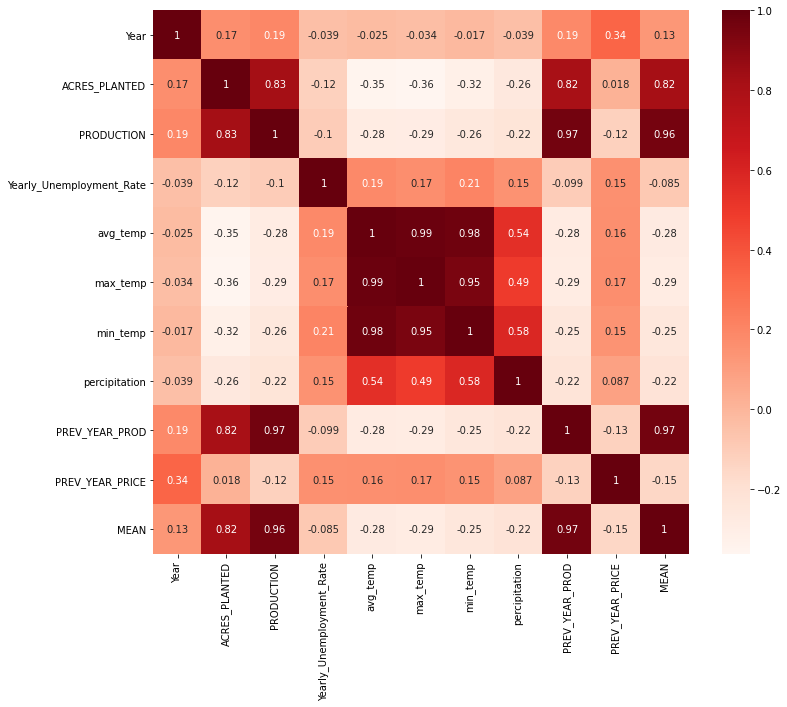

In [5]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = crop_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [6]:
#Focusing on hihly related features.
cor_matrix = cor.drop(columns='PRODUCTION')
cor_matrix = cor_matrix.drop(index='PRODUCTION')
cor_matrix[cor_matrix>0.5]

,Year,ACRES_PLANTED,Yearly_Unemployment_Rate,avg_temp,max_temp,min_temp,percipitation,PREV_YEAR_PROD,PREV_YEAR_PRICE,MEAN
Year,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACRES_PLANTED,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.818529,NaN,0.820287
Yearly_Unemployment_Rate,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_temp,NaN,NaN,NaN,1.000000,0.989251,0.978170,0.544021,NaN,NaN,NaN
max_temp,NaN,NaN,NaN,0.989251,1.000000,0.946298,NaN,NaN,NaN,NaN
min_temp,NaN,NaN,NaN,0.978170,0.946298,1.000000,0.584799,NaN,NaN,NaN
percipitation,NaN,NaN,NaN,0.544021,NaN,0.584799,1.000000,NaN,NaN,NaN
PREV_YEAR_PROD,NaN,0.818529,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.967085
PREV_YEAR_PRICE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
MEAN,NaN,0.820287,NaN,NaN,NaN,NaN,NaN,0.967085,NaN,1.000000


In [7]:
#Selecting features
features_set = list(crop_df.columns)

# dropping highly corrected features

# Weather columns: most of them are highly correlated, but amoungs them Max tempeture has better correlation with target variable.
# And percipitation is also less related to max temperatue. Keeping these two dropping others.
features_set.remove('min_temp')
features_set.remove('avg_temp')

# Production related columns: all of them (ACRES_PLANTED, PREV_YEAR_PROD, MEAN) are highly correlated to production and among each other.
# With such a high correction PREV_YEAR_PROD and MEAN, are direct hint to current year production.
# Limiting to ACRES_PLANTED will keep model relatively balanced. removing remaining.
features_set.remove('PREV_YEAR_PROD')
features_set.remove('MEAN')

#Finally dropping target variable.
filtered_df = crop_df[features_set]
del crop_df
filtered_df.head()

,CROP,Year,ACRES_PLANTED,PRODUCTION,Yearly_Unemployment_Rate,max_temp,percipitation,State-County,PREV_YEAR_PRICE
0,BARLEY,1985,900,4200000,6.333333,53.2,1.95,ARIZONA COCHISE,0.062500
1,BARLEY,1986,500,2016000,6.925000,65.0,0.15,ARIZONA COCHISE,0.058750
2,BARLEY,1987,500,2304000,6.450000,58.4,0.54,ARIZONA COCHISE,0.051458
3,BARLEY,1989,500,2116800,5.358333,56.8,1.32,ARIZONA COCHISE,0.045625
4,BARLEY,1991,1400,6864000,5.966667,56.3,1.55,ARIZONA COCHISE,0.064583


### Encoding Categories

There are two categorical columns that needs to be encoded, since regression doesn't work well with text values.

#### Prediction with OneHot Encoder

This encoder cannot be used since increases the dimensionality of the data significantly.

In [8]:
from sklearn.preprocessing import OneHotEncoder
# encoding categorical values of CROP and State-County
oneH_encoded_df = filtered_df.copy()
oneH_encoded_df=pd.get_dummies(oneH_encoded_df,prefix=None)
print(oneH_encoded_df.columns)
del oneH_encoded_df

Index(['Year', 'ACRES_PLANTED', 'PRODUCTION', 'Yearly_Unemployment_Rate',
       'max_temp', 'percipitation', 'PREV_YEAR_PRICE', 'CROP_BARLEY',
       'CROP_CORN', 'CROP_PEANUTS',
       ...
       'State-County_WYOMING NATRONA', 'State-County_WYOMING NIOBRARA',
       'State-County_WYOMING PARK', 'State-County_WYOMING PLATTE',
       'State-County_WYOMING SHERIDAN', 'State-County_WYOMING SWEETWATER',
       'State-County_WYOMING TETON', 'State-County_WYOMING UINTA',
       'State-County_WYOMING WASHAKIE', 'State-County_WYOMING WESTON'],
      dtype='object', length=2738)


#### Hashing categorical values

Using hashing seems to be a good option, since it keeps the hashed columns independent of any other variables in the data with small number of extra columns. But some information about the original columns might have lost.<br>
We create two groups of features, all features and features with no hints about the production value (so excluding Acers planted, Previous year production and mean historical production).

In [10]:
from category_encoders.hashing import HashingEncoder
from sklearn.preprocessing import MinMaxScaler

#Hash encoding state and Crop columns
h_encoded_df = filtered_df.copy()
hasher = HashingEncoder(return_df=True)
h_encoded_df = hasher.fit_transform(filtered_df)

#One hot encoding Year.
#Year has significant influence when it comes to production value. So we do not want to loose that information.
#Hence one hot encoding.
h_encoded_df['Year']=h_encoded_df.Year.astype('str')
onehot_encoded_df = pd.get_dummies(h_encoded_df)

#Since all the features have varing scale, it will be difficult to asses each influence on the target column.
#So we will scale all continous columns to the same range of binary columns (0-1).
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(onehot_encoded_df),columns=onehot_encoded_df.columns)
print(scaled_df.head())

   col_0  col_1  col_2  col_3  col_4  col_5  col_6  col_7  ACRES_PLANTED  \
0    0.0    0.0    0.0    1.0    0.0    0.0    0.5    0.0       0.001654   
1    0.0    0.0    0.0    1.0    0.0    0.0    0.5    0.0       0.000915   
2    0.0    0.0    0.0    1.0    0.0    0.0    0.5    0.0       0.000915   
3    0.0    0.0    0.0    1.0    0.0    0.0    0.5    0.0       0.000915   
4    0.0    0.0    0.0    1.0    0.0    0.0    0.5    0.0       0.002579   

   PRODUCTION  ...  Year_2008  Year_2009  Year_2010  Year_2011  Year_2012  \
0    0.000971  ...        0.0        0.0        0.0        0.0        0.0   
1    0.000466  ...        0.0        0.0        0.0        0.0        0.0   
2    0.000533  ...        0.0        0.0        0.0        0.0        0.0   
3    0.000489  ...        0.0        0.0        0.0        0.0        0.0   
4    0.001587  ...        0.0        0.0        0.0        0.0        0.0   

   Year_2013  Year_2014  Year_2015  Year_2016  Year_2017  
0        0.0        0

In [11]:
#Creating feature list
hash_features = list(scaled_df.columns)
hash_features.remove('PRODUCTION')

#Features that has no hint of previous year production
hintless_hashFeatures = hash_features.copy()
hintless_hashFeatures.remove('ACRES_PLANTED')

#Holds both the features into one set.
hash_features_set = [hash_features, hintless_hashFeatures]

Using the feature set above we would test both the feature set with 2 different algorithms, namely random forest and linear regression. Linear regression seems a obvious choice since we are predicting a continous value. Random Forest regressor, has a reputation of of yielding better results compared individual algorithms.<br><br>
We will fine tune the model for, <br>
Random Forest: Number of features that goes into each individual tree and the total number of trees.<br>
Linear Regression: If or not the feature values should be normalized.<br>
We will be using GridsearchCV to tune these parameters and cross validate our results with 3 folds.<br>
<br>
We will validate our results using multiple ways, r-sqaure score, error distribution from actual, error histogram and ECDF of the error values. 

In [12]:
from sklearn.model_selection import GridSearchCV

def ecdf(data):
    # Compute ECDF for a one-dimensional array of measurements.
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

def plot_metrics(y_test,y_predict):
    # Dataframe of Actaul values and difference between predicted values and actuals. 
    y_df = pd.DataFrame({'Actual':y_test,'Predicted':y_predict,'Differece':np.abs(y_test-y_predict), \
                         'Precent diff': (np.abs(y_test-y_predict)/y_test)*100})
    
    # Plots variation in absolute error from actual.
    plt.figure(figsize=(15,8))
    ax1 = plt.subplot(2,2,1)
    sns.scatterplot('Actual', 'Differece', data=y_df,markers=True,color='r').set_title('Variation of error with actual')

    # Plots ECDF of error, a different way of looking at the distribution. 
    # It shows what percentage of values below given value.
    ax2 = plt.subplot(2,2,2)
    x,y = ecdf(np.abs(y_df['Differece']))
    sns.lineplot(x, y).set_title('ECDF of error')
    plt.xlabel('Difference')
    plt.ylabel('Percent less than')
    
    # Distribution of error.
    plt.figure(figsize=(20,10))
    ax3 = plt.subplot(2,2,3)
    plt.hist(y_df['Precent diff'],bins=np.arange(0,100,10))
    plt.title('Error distribution')
    plt.show()
    return y_df
    

def print_metrics(clf, model_type, y_test, X_test, features):
    print('\tCV Results',pd.DataFrame(clf.cv_results_))
    print('\tBest parameters: ',clf.best_params_)
    print('\tBest scores: ',clf.best_score_)
    
    if model_type=='random_forest':
        print('\tFeature importance:',np.around(clf.best_estimator_.feature_importances_,4)*100)
    elif model_type=='linear':
        print('\tCoefficients: ',clf.best_estimator_.coef_)
    
    print('\tTest Score:',clf.score(X_test[features],y_test))
    
    print('\n\n Below are couple of ways to look at the results.')


# Test models for different features sets for different algorithms (linear and Random Forest).
# With GridsearchCV parameters are tuned.
def test_model(features,data, model_type):
    print('Features:\n',features)
    
    #selects algorithm.
    if model_type=='random_forest':
        #testing number of features each tree gets, and number of trees.
        parameters = {'max_depth':[15,30,45], 'min_samples_leaf':[1,2,4]}
        #Setting random state for consistance results.
        model = RandomForestRegressor(random_state=10, n_jobs=-1,oob_score=True,max_features='auto',n_estimators=650)
        scoringFunc=['explained_variance','r2','neg_mean_squared_error']
    elif model_type=='linear':
        #testing effect of normalization
        parameters = {'normalize':['True','False']}
        model = LinearRegression(n_jobs=-1,fit_intercept=False)
        scoringFunc='r2'

    # Seperating target variable from features, then spliting train and test data sets. 
    # With 20% as test.
    X=data[features]
    y=data['PRODUCTION']
    
    
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)
    
    #Paramter tuning with 3-fold grid search.
    clf = GridSearchCV(model, parameters, cv=5, scoring=scoringFunc,return_train_score=True, iid=True, refit='explained_variance')
    
    clf.fit(X_train[features],y_train)
    
    print_metrics(clf, model_type, y_test, X_test, features)
   
    #Predicting values.
    y_predict = clf.predict(X_test)
    
    y_df = plot_metrics(y_test,y_predict)
    
    #house cleaning
#     del y_df
    print('='*50)
    return clf, y_df

With GridSearchCV with a random forest model, the results are clear, having no hint at all the prediction suffers. While using all the features the model predicts with a high score. No surprise the model puts heavy emphasis on Acres Planted (feature importance). <br>

Features:
 ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'ACRES_PLANTED', 'Yearly_Unemployment_Rate', 'max_temp', 'percipitation', 'PREV_YEAR_PRICE', 'Year_1985', 'Year_1986', 'Year_1987', 'Year_1988', 'Year_1989', 'Year_1990', 'Year_1991', 'Year_1992', 'Year_1993', 'Year_1994', 'Year_1995', 'Year_1996', 'Year_1997', 'Year_1998', 'Year_1999', 'Year_2000', 'Year_2001', 'Year_2002', 'Year_2003', 'Year_2004', 'Year_2005', 'Year_2006', 'Year_2007', 'Year_2008', 'Year_2009', 'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015', 'Year_2016', 'Year_2017']
	CV Results    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      71.187166      1.531380         1.245816        0.008884   
1      67.258442      0.115167         0.990632        0.129638   
2      66.541238      0.126622         0.926100        0.002161   
3      90.318183      0.456589         2.472043        0.005255   
4      84.955288      0.184363         1.972073

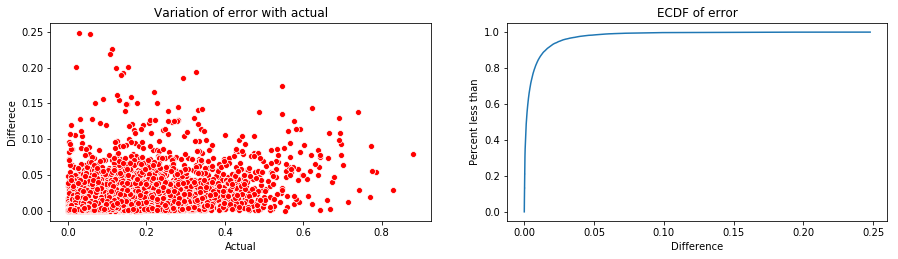

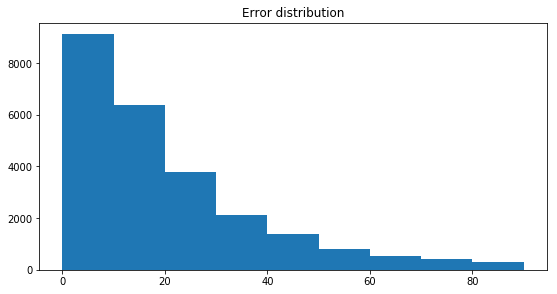

Features:
 ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'Yearly_Unemployment_Rate', 'max_temp', 'percipitation', 'PREV_YEAR_PRICE', 'Year_1985', 'Year_1986', 'Year_1987', 'Year_1988', 'Year_1989', 'Year_1990', 'Year_1991', 'Year_1992', 'Year_1993', 'Year_1994', 'Year_1995', 'Year_1996', 'Year_1997', 'Year_1998', 'Year_1999', 'Year_2000', 'Year_2001', 'Year_2002', 'Year_2003', 'Year_2004', 'Year_2005', 'Year_2006', 'Year_2007', 'Year_2008', 'Year_2009', 'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015', 'Year_2016', 'Year_2017']
	CV Results    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      63.242214      0.295097         1.236318        0.002557   
1      62.200945      0.158771         1.239575        0.002658   
2      61.639967      0.119533         0.923570        0.000626   
3      88.860195      0.234113         2.784871        0.005164   
4      83.051463      0.430599         2.415358        0.035967 

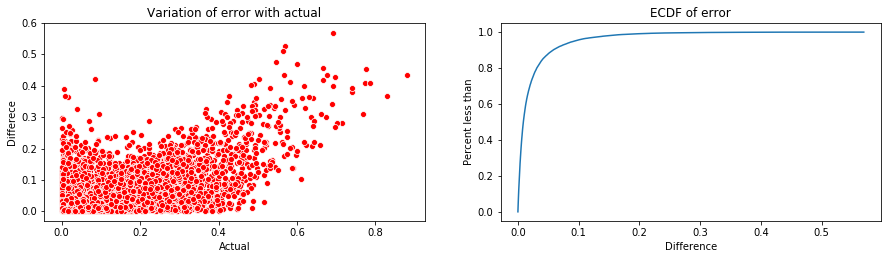

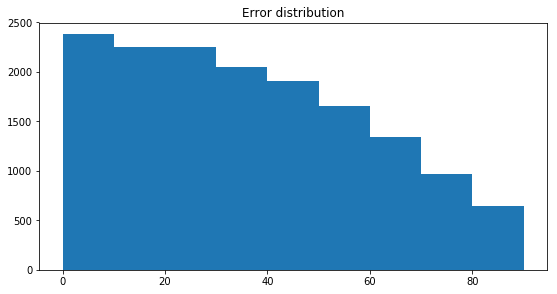

In [25]:
models = results = [None]*2

for i, feature in enumerate(hash_features_set):
    clf, y_df= test_model(feature, scaled_df,'random_forest')
    models[i] = clf
    results[i] = y_df

Percentage of error in and below each bucket: [0.36593694 0.62193211 0.7743322  0.86013256 0.91588672 0.94874473
 0.97083752 0.98802972 1.        ]


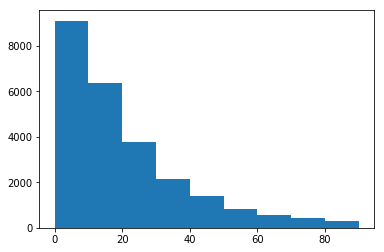

In [38]:
n, bins, patches  = plt.hist(results[0]['Precent diff'],bins=np.arange(0,100,10))
print('Percentage of error in and below each bucket:',np.cumsum(n/np.sum(n)))

## Linear Regression

Using linear regression instead produces a less favorable model compared to a random forest. But overall the importance of the features remained the same, with a small change in hashed out columns.

Features:
 ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'ACRES_PLANTED', 'Yearly_Unemployment_Rate', 'max_temp', 'percipitation', 'PREV_YEAR_PRICE', 'Year_1985', 'Year_1986', 'Year_1987', 'Year_1988', 'Year_1989', 'Year_1990', 'Year_1991', 'Year_1992', 'Year_1993', 'Year_1994', 'Year_1995', 'Year_1996', 'Year_1997', 'Year_1998', 'Year_1999', 'Year_2000', 'Year_2001', 'Year_2002', 'Year_2003', 'Year_2004', 'Year_2005', 'Year_2006', 'Year_2007', 'Year_2008', 'Year_2009', 'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015', 'Year_2016', 'Year_2017']
	CV Results    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.073398      0.003424         0.003192    3.994704e-04   
1       0.072606      0.001466         0.002992    1.907349e-07   

  param_normalize                  params  split0_test_score  \
0            True   {'normalize': 'True'}           0.735736   
1           False  {'normalize': 'False'}           

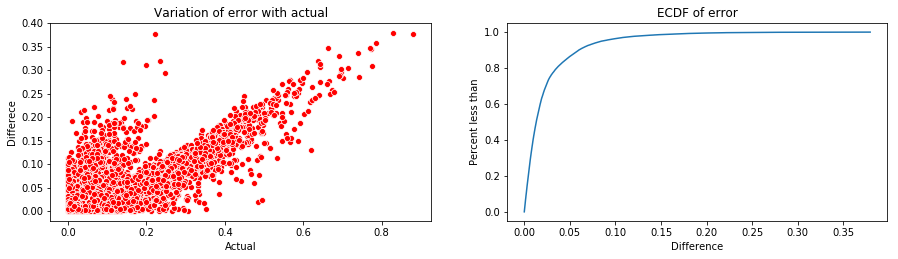

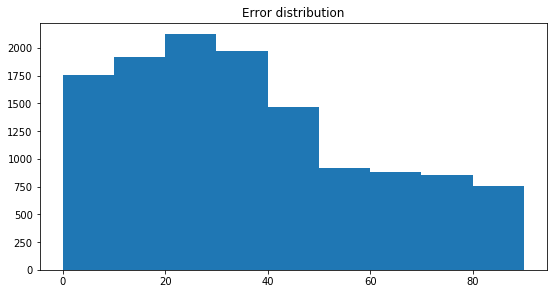

Features:
 ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'Yearly_Unemployment_Rate', 'max_temp', 'percipitation', 'PREV_YEAR_PRICE', 'Year_1985', 'Year_1986', 'Year_1987', 'Year_1988', 'Year_1989', 'Year_1990', 'Year_1991', 'Year_1992', 'Year_1993', 'Year_1994', 'Year_1995', 'Year_1996', 'Year_1997', 'Year_1998', 'Year_1999', 'Year_2000', 'Year_2001', 'Year_2002', 'Year_2003', 'Year_2004', 'Year_2005', 'Year_2006', 'Year_2007', 'Year_2008', 'Year_2009', 'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015', 'Year_2016', 'Year_2017']
	CV Results    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.070801      0.002090         0.002992    4.422006e-07   
1       0.073005      0.002221         0.003392    4.886166e-04   

  param_normalize                  params  split0_test_score  \
0            True   {'normalize': 'True'}           0.190864   
1           False  {'normalize': 'False'}           0.190864   

   s

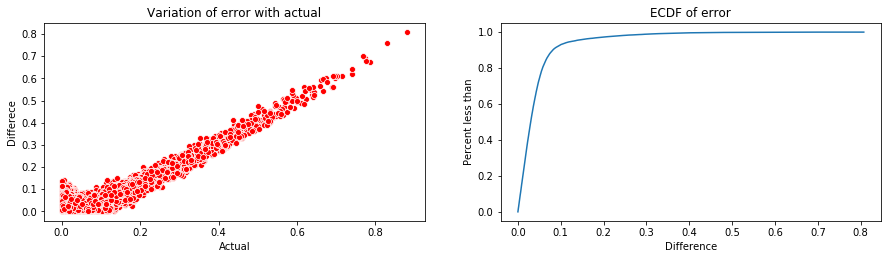

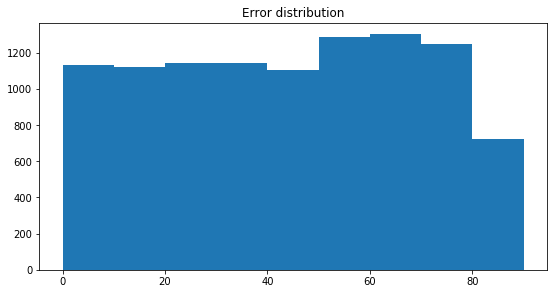

In [17]:
for features in hash_features_set:
   test_model(features,scaled_df,'linear')

In [18]:
from statsmodels.formula.api import ols
m = ols('PRODUCTION ~ Year+PREV_YEAR_PRICE+Yearly_Unemployment_Rate+max_temp+percipitation',h_encoded_df).fit()
print(m.summary())
del m

                            OLS Regression Results                            
Dep. Variable:             PRODUCTION   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     721.0
Date:                Wed, 12 Jun 2019   Prob (F-statistic):               0.00
Time:                        21:56:47   Log-Likelihood:            -2.8846e+06
No. Observations:              137533   AIC:                         5.769e+06
Df Residuals:                  137496   BIC:                         5.770e+06
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Conclusion
By looking at above results, over all based on score random forest algorithm yields better results in this case. More specifically using Acers Planted as one of the features, yields the highest score. You can see from the differnt metrics above, <br>
<b>Test Score:</b> Random forest with all the feature (option 1) outperforms all other options with a highest score of -0.00013432905644238577.<br>
<b>Variation of error (actaul-predicted):</b> The variation is far less in option 1 vs all other. The key indication is the y-axis scale, which is limited to 0.25 and even within that the error is mostly limited to 0.15.<br>
<b>Error distribution:</b> As can be seen, the values are around 0 in most of the cases. But with option 1, most of it is between 0-10% and gradually reducing. Others mostly have flat or even distribution, meaning equal amount of error even as we move away from actuals.<br>
<b>ECDF of error:</b> Even here the graph rises very quickly to 100%, indicating that 100% of error values lie below a smaller value.<br>

Thus, option 1 (random forest with all the features) yield really good results, and gives a good confidence in using it as a base model.